# Data Preprocessing, Customer Clustering using K-Means, and Association Rule Mining - Online Retail Dataset from the UCI Machine Learning Repository

### Step 1: Load the Dataset

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_excel("Online Retail.xlsx")

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### Step 2: Handle Missing Values

#### 2. Missing value handling
*Check if there are missing values using isnull().sum()
*Also checking zero values in numerical columns. I consider 0 value as a missing values.

In [11]:
missing = pd.DataFrame({'Missing Count': df.isnull().sum(),
                        'Missing Percentage': (df.isnull().mean()*100).apply(lambda x: f'{x:.2f}%')})
missing

,Missing Count,Missing Percentage
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,1454,0.27%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,135080,24.93%
Country,0,0.00%


#### Handling missing value for CustomerID

In [13]:
#Filling the missing CustomerID with a placeholder:  "Anonymous" since it's required for customer segmentation

df['CustomerID'] = df['CustomerID'].fillna('Anonymous')

#### Result verification for CustomerID missing data

In [15]:
# Check if there are still missing CustomerID
print(df["CustomerID"].isnull().sum())

0


#### Handling missing value for Description

#### 1. Create a Mapping of StockCode to Description: 
To creates a dictionary where the key is StockCode(a 5-digit integral number uniquely assigned to each distinct product) and the value is the most frequent Description(product name) for that StockCode.ing

In [17]:
# Group by StockCode and get the most frequent Description for each StockCode
description_mapping = df.dropna(subset=['Description'])  # Drop rows with missing Description
description_mapping = description_mapping.groupby('StockCode')['Description'].agg(lambda x: x.mode()[0]).to_dict()

#### 2. Impute Missing Description Values Using the Mapping
This function below checks if Description is missing and if the StockCode exists in the mapping. If both conditions are met, it fills the missing Description with the corresponding value from the mapping.

In [19]:
# Define a function to impute missing descriptions
def impute_description(row):
    if pd.isna(row['Description']) and row['StockCode'] in description_mapping:
        return description_mapping[row['StockCode']]
    return row['Description']

# Apply the function to fill missing descriptions
df['Description'] = df.apply(impute_description, axis=1)

#### Result verification for descriptions missing data

In [20]:
# Check if there are still missing descriptions
print(df['Description'].isnull().sum())

112


#### Filling the remaining description missing data with a Placeholder: "Unknown" 

In [23]:
df['Description'] = df['Description'].fillna('Unknown')

In [25]:
# Check if there are still missing descriptions
print(df['Description'].isnull().sum())

0


##### Verification of Missing data Handling

In [27]:
missing = pd.DataFrame({'Missing Count': df.isnull().sum(),
                        'Missing Percentage': (df.isnull().mean()*100).apply(lambda x: f'{x:.2f}%')})
missing

,Missing Count,Missing Percentage
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,0,0.00%
Country,0,0.00%


In [29]:
(df == 0).sum() #Also, zero values in numerical columns are checked. I consider the 0 value as a missing value.

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice      2515
CustomerID        0
Country           0
dtype: int64

#### I used "StockCode" along with "Description", to compute unit price for each product with 0 value

In [31]:
df['UnitPrice'] = df.groupby('StockCode')['UnitPrice'].transform(lambda x: x.replace(0, x.median()))

In [33]:
(df == 0).sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
InvoiceDate      0
UnitPrice      162
CustomerID       0
Country          0
dtype: int64

In [35]:
df = df[df['UnitPrice'] > 0] #To keep only rows where UnitPrice is greater than zero in my dataset

In [37]:
print(df['UnitPrice'].eq(0).sum())  # I verified to ensure no Zero values remain in my dataset


0


### Step 3: Convert categorical variables into numerical representations if necessary

In [39]:
def count_unique_values(df, column_name):
   
    if column_name in df.columns:
        unique_count = df[column_name].nunique()
        return unique_count
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None


# Count unique InvoiceNo values
invoice_unique_count = count_unique_values(df, 'InvoiceNo')
if invoice_unique_count is not None:
    print(f"Number of unique InvoiceNo values: {invoice_unique_count}")

# Count unique StockCode values
stock_unique_count = count_unique_values(df, 'StockCode')
if stock_unique_count is not None:
    print(f"Number of unique StockCode values: {stock_unique_count}")

# Get the unique InvoiceNo values
unique_invoices = df['InvoiceNo'].unique()
print(f"Unique InvoiceNo values: {unique_invoices}")

# Get the unique StockCode values
unique_stocks = df['StockCode'].unique()
print(f"Unique StockCode values: {unique_stocks}")

# Get the counts of each InvoiceNo
invoice_counts = df['InvoiceNo'].value_counts()
print(f"Counts of InvoiceNo:\n{invoice_counts}")

# Get the counts of each StockCode
stock_counts = df['StockCode'].value_counts()
print(f"Counts of StockCode:\n{stock_counts}")

Number of unique InvoiceNo values: 25737
Number of unique StockCode values: 3938
Unique InvoiceNo values: [536365 536366 536367 ... 581585 581586 581587]
Unique StockCode values: ['85123A' 71053 '84406B' ... '90214U' '47591b' 23843]
Counts of InvoiceNo:
InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
570712       1
570711       1
570710       1
570709       1
549494       1
Name: count, Length: 25737, dtype: int64
Counts of StockCode:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
m            1
85160a       1
84839        1
84661b       1
84536b       1
Name: count, Length: 3938, dtype: int64


### The columns(Stockcode and InvoiceNo) have high cardinality with a large number of unique values which are repeated frequently, 
I converted them to categorical types to save memory and improve performance.

##### Memory usage Before conversion

In [41]:

print("Memory usage before conversion:")
print(df.memory_usage(deep=True))

Memory usage before conversion:
Index           4333960
InvoiceNo      19688600
StockCode      20536217
Description    40980401
Quantity        4333960
InvoiceDate     4333960
UnitPrice       4333960
CustomerID     20843656
Country        33791894
dtype: int64


### Converting InvoiceNo and StockCode to categorical types

In [43]:

df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')

# Verify the data types
print(df.dtypes)

InvoiceNo            category
StockCode            category
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


#### Memory usage after converting to categorical types:

In [45]:
print("Memory usage after conversion:")
print(df.memory_usage(deep=True))

Memory usage after conversion:
Index           4333960
InvoiceNo       3143570
StockCode       1377533
Description    40980401
Quantity        4333960
InvoiceDate     4333960
UnitPrice       4333960
CustomerID     20843656
Country        33791894
dtype: int64


#### The conversion significantly reduced memory usage, especially for InvoiceNo and StockCode, likely by changing them from object types to more efficient numerical or categorical types. Other columns remained unchanged. This optimization improves performance, speeds up computations, and enhances scalability.

### Step 4:Remove duplicate records

In [47]:
df.duplicated().sum()

5269

#### Removing duplicates to ensure my dataset has no duplicate entries which can skew my analysis

In [49]:
df.drop_duplicates(inplace=True)

#### Confirm duplicates removed

In [51]:
df.duplicated().sum()

0

### Step 5: Creating a New Feature 'Total Price' (5 Marks) : This helps in analyzing sales trends and customer spending patterns

In [53]:
#Compute Total Price = Quantity * UnitPrice.

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Display updated dataset
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Step 6: Normalize Numerical Features

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536476 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536476 non-null  category      
 1   StockCode    536476 non-null  category      
 2   Description  536476 non-null  object        
 3   Quantity     536476 non-null  int64         
 4   InvoiceDate  536476 non-null  datetime64[ns]
 5   UnitPrice    536476 non-null  float64       
 6   CustomerID   536476 non-null  object        
 7   Country      536476 non-null  object        
 8   TotalPrice   536476 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 36.2+ MB


#### Normalize Quantity, UnitPrice, and TotalPrice: using MinMax
MinMax Scaling brings numerical features to a 0-1 range, making them easier to analyze.

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize numerical columns
df[["Quantity", "UnitPrice", "TotalPrice"]] = scaler.fit_transform(df[["Quantity", "UnitPrice", "TotalPrice"]])

# Display normalized dataset
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,0.500037,2010-12-01 08:26:00,0.000065,17850.0,United Kingdom,0.476741
1,536365,71053,WHITE METAL LANTERN,0.500037,2010-12-01 08:26:00,0.000087,17850.0,United Kingdom,0.476755
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,0.500049,2010-12-01 08:26:00,0.000071,17850.0,United Kingdom,0.476760
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,0.500037,2010-12-01 08:26:00,0.000087,17850.0,United Kingdom,0.476755
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,0.500037,2010-12-01 08:26:00,0.000087,17850.0,United Kingdom,0.476755


### Step 7: Display Summary Statistics and Visualizations

In [59]:
# Summarize dataset statistics 
print(df.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  536476.000000                         536476  536476.000000   
mean        0.500060  2011-07-04 09:37:42.373191168       0.000120   
min         0.000000            2010-12-01 08:26:00       0.000000   
25%         0.500006            2011-03-28 11:34:00       0.000032   
50%         0.500019            2011-07-19 14:29:00       0.000054   
75%         0.500062            2011-10-18 17:05:00       0.000106   
max         1.000000            2011-12-09 12:50:00       1.000000   
std         0.001351                            NaN       0.002435   

          TotalPrice  
count  536476.000000  
mean        0.476749  
min         0.000000  
25%         0.476708  
50%         0.476726  
75%         0.476747  
max         1.000000  
std         0.001309  


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

### A. Distribution of Unit Price

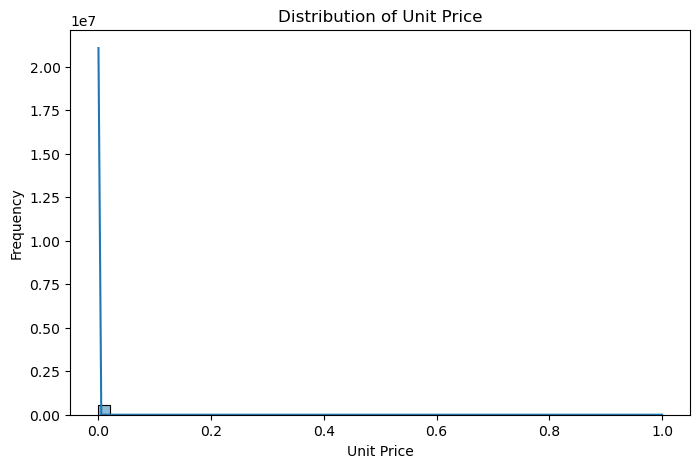

In [362]:

plt.figure(figsize=(8,5))
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title("Distribution of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.show()

#### INSIGHTS:
*The histogram shows a highly skewed distribution of unit prices, with the vast majority of items clustered near a price of zero.

*A significant spike in frequency occurs at the lowest price range, suggesting a large volume of items priced very low.

*The distribution quickly tapers off, indicating very few items with higher unit prices.

*This pattern suggests a potential data issue, such as a large number of free or incorrectly priced items, or it could reflect a business model heavily reliant on extremely low-cost products.

### B. Top 10 Most Frequent Products Sold

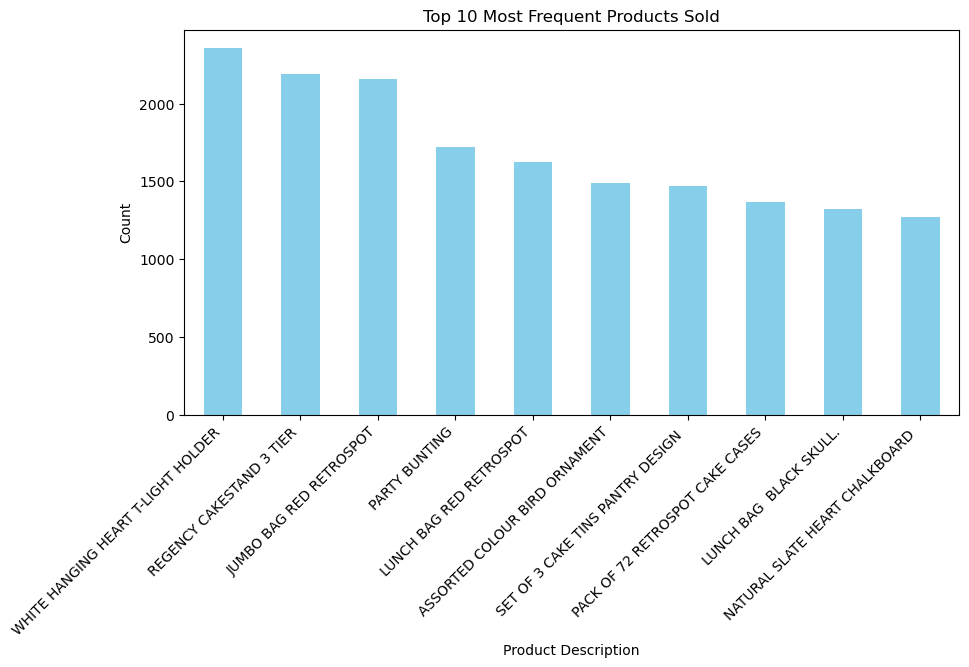

In [364]:
plt.figure(figsize=(10,5))
df['Description'].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Frequent Products Sold")
plt.xlabel("Product Description")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

#### INSIGHT: This chart shows the top 10 best-selling products, with "WHITE HANGING HEART T-LIGHT HOLDER" being the most popular. There's a steep drop-off in sales after the top 3.  The variety of products suggests diverse customer interests, with a noticeable trend towards retro designs.

### C. Total Sales Per Country

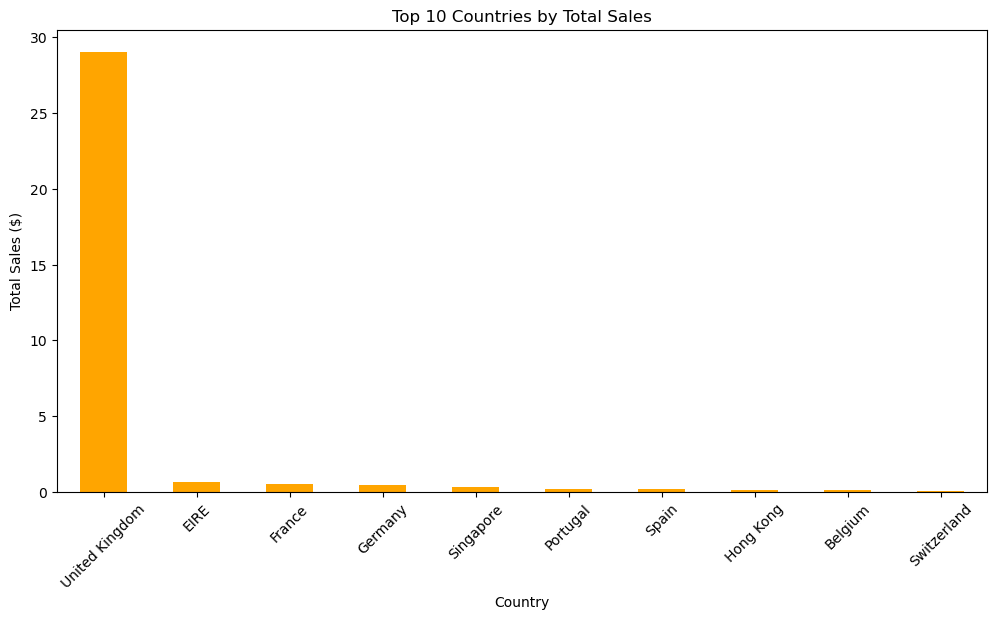

In [366]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

plt.figure(figsize=(12,6))
df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Countries by Total Sales")
plt.xlabel("Country")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()

#### INSIGHT: The UK is the primary source of sales, significantly exceeding other countries. This suggests a strong market presence in the United Kingdom while exploring growth opportunities in other markets

### D. Monthly Sales Trend
I converted InvoiceDate to datetime to analyze monthly sales trends:

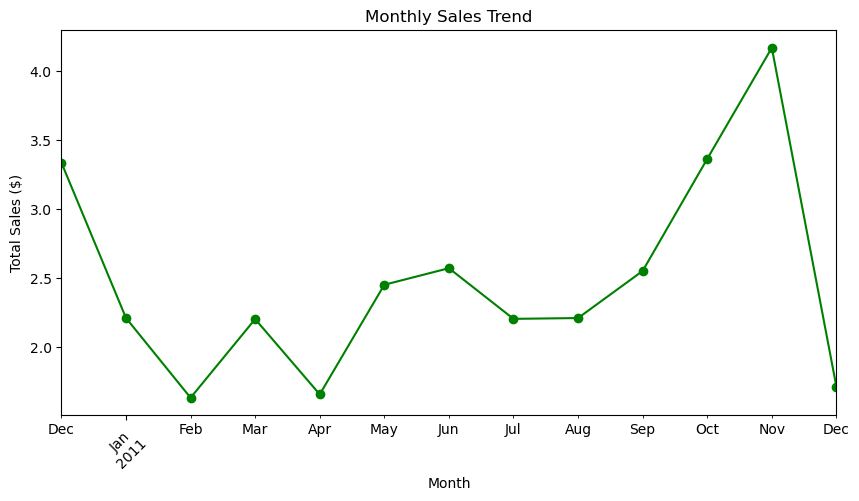

In [368]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  
df['Month'] = df['InvoiceDate'].dt.to_period('M')

plt.figure(figsize=(10,5))
df.groupby('Month')['TotalPrice'].sum().plot(marker='o', linestyle='-', color='green')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()


#### INSIGHT: This chart shows a clear seasonal sales trend with the highest sales in November, likely due to holiday shopping. February has the lowest sales, indicating a potential post-holiday slump.  Sales steadily increase from April to November, suggesting an opportunity for growth during these months. Businesses can use this information to plan inventory and marketing strategies based on the seasonal fluctuations.

## Task 2: Customer Clustering using K-Means
Using K-Means clustering to group similar customers based on their purchase behavior .

### Step 1: Select Relevant Features for Clustering 

#### Common features include:
*Total Spending (TotalPrice = Quantity × UnitPrice)
*Frequency of Purchases (Number of Transactions per Customer)

In [63]:
# Aggregate data at the customer level
customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",  # Number of purchases (frequency)
    "TotalPrice": "sum"      # Total spending
}).reset_index()

# Rename columns
customer_df.rename(columns={"InvoiceNo": "NumPurchases"}, inplace=True)

# Display the processed dataset
customer_df.head()

,CustomerID,NumPurchases,TotalPrice
0,12346.0,2,0.953396
1,12347.0,7,86.771206
2,12348.0,4,14.782719
3,12349.0,1,34.803917
4,12350.0,1,8.104810


### Step 2: Normalize Features Before Applying K-Means
Since NumPurchases and TotalPrice have different scales, I normalized them using MinMaxScaler to ensure both features contribute equally to clustering.

In [65]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply normalization
customer_df[["NumPurchases", "TotalPrice"]] = scaler.fit_transform(customer_df[["NumPurchases", "TotalPrice"]])

# Display normalized data
customer_df.head()


,CustomerID,NumPurchases,TotalPrice
0,12346.0,0.000282,0.000008
1,12347.0,0.001692,0.001342
2,12348.0,0.000846,0.000223
3,12349.0,0.000000,0.000534
4,12350.0,0.000000,0.000119


### Step 3: Use the Elbow Method to Determine Optimal Clusters
I determine the optimal number of clusters (K) using the Elbow Method, which plots inertia (WCSS) vs. number of clusters.

In [27]:
pip install -U scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


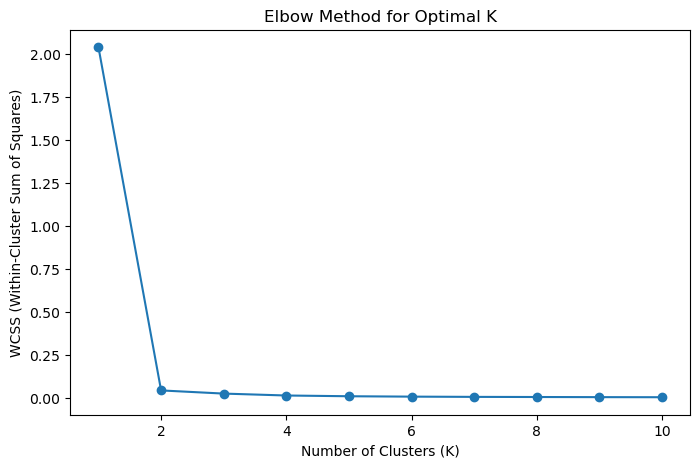

In [67]:

from sklearn.cluster import KMeans

# Try different values of K
wcss = []
K_range = range(1, 11)  # Testing K from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_df[["NumPurchases", "TotalPrice"]])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()


#### Conclusion

Based on this Elbow Method plot, the optimal number of clusters for my K-Means clustering is K=2 (I picked K where WCSS stops decreasing significantly). 

This is because:
It captures a significant reduction in WCSS compared to K=1.
Adding more clusters beyond 2 doesn't provide a significant improvement, suggesting that the data is well-separated into two distinct groups.

### Step 4: Apply K-Means Algorithm & Interpret Clusters
I applied K-Means clustering with the optimal K = 2.

In [94]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit and predict cluster labels
customer_df["Cluster"] = kmeans.fit_predict(customer_df[["NumPurchases", "TotalPrice"]])

# Display cluster assignments
customer_df.head()


,CustomerID,NumPurchases,TotalPrice,Cluster
0,12346.0,0.000282,0.000008,0
1,12347.0,0.001692,0.001342,0
2,12348.0,0.000846,0.000223,0
3,12349.0,0.000000,0.000534,0
4,12350.0,0.000000,0.000119,0


#### Interpretation of Clusters:

Cluster 0 → Low spending, lower purchase frequency
Cluster 1 → High spending, Higher purchase frequency

### Step 5: Visualize Clustering Results Using Scatter Plots
I ploted customers in different clusters

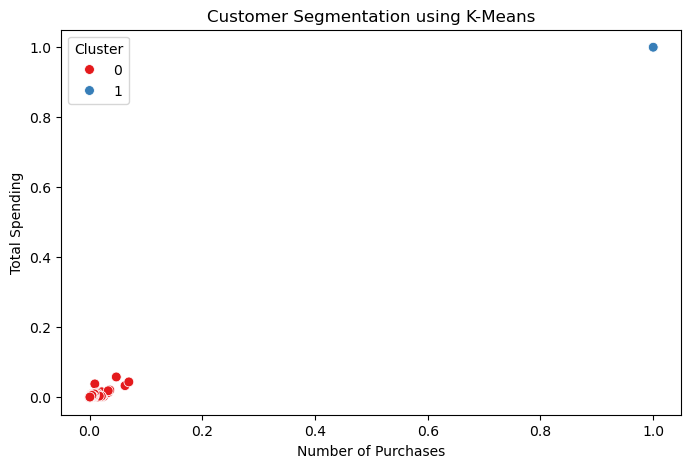

In [96]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_df, x="NumPurchases", y="TotalPrice", hue="Cluster", palette="Set1", s=50)
plt.xlabel("Number of Purchases")
plt.ylabel("Total Spending")
plt.title("Customer Segmentation using K-Means")
plt.show()


#### Conclusion: This scatter plot shows two distinct customer groups based on their number of purchases and total spending. One cluster represents low-value customers with low purchases and spending, while the other cluster has a single high-value outlier. This segmentation allows businesses to develop targeted marketing strategies for each group. The outlier customer warrants further analysis to understand their unique behavior.

### Step 6: Evaluate Clustering Quality Using Silhouette Score
I used the silhouette score to measure how well-separated the clusters are.

In [98]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
silhouette_avg = silhouette_score(customer_df[["NumPurchases", "TotalPrice"]], customer_df["Cluster"])
print(f"Silhouette Score: {silhouette_avg:.2f}")


Silhouette Score: 1.00


#### K=2 (Silhouette Score: 1.00): This is a perfect score! It indicates that with two clusters, the data points are perfectly separated and assigned to the most appropriate cluster. There's no ambiguity in cluster assignments.

### Step 7: Business Insights from Customer Segmentation
How businesses can use these insights:
Customer segmentation is a powerful tool that allows businesses to group customers based on shared characteristics, behaviors, or preferences. These insights can be leveraged across various business functions to improve efficiency, effectiveness, and profitability. Here's how:

1. Targeted Marketing:

Personalized Campaigns: Craft marketing messages and offers tailored to specific customer segments. For example, high-value customers might receive exclusive offers or early access to new products, while price-sensitive customers might respond better to discounts and promotions.
Channel Optimization: Determine the most effective channels to reach each segment. Younger audiences might be more responsive to social media campaigns, while older demographics might prefer email or direct mail.
Product Development: Identify unmet needs or preferences within segments to guide product development and innovation.

2. Customer Experience:

Personalized Service: Provide tailored customer service based on segment needs and preferences. High-value customers might receive priority support or dedicated account managers.
Improved Communication: Communicate with customers in a way that resonates with their segment. Use language, tone, and style that aligns with their preferences.
Loyalty Programs: Design loyalty programs that cater to the specific needs and motivations of different segments.

3. Sales and Revenue:

Cross-selling and Upselling: Identify opportunities to cross-sell or upsell products or services based on the purchase history and preferences of each segment.
Pricing Strategies: Develop pricing strategies that align with the price sensitivity and value perception of different segments.
Customer Retention: Implement strategies to retain high-value customers and reduce churn.

4. Operational Efficiency:

Resource Allocation: Allocate resources effectively by focusing on the most valuable customer segments.
Inventory Management: Optimize inventory levels based on the anticipated demand from different segments.
Customer Support: Tailor customer support resources to address the specific needs and issues of different segments.

Examples:

A clothing retailer might segment customers by age, gender, and style preferences to personalize product recommendations and marketing messages.

A software company might segment customers by usage patterns and needs to offer different pricing plans and support levels.

A travel agency might segment customers by travel style and budget to create customized travel packages and experiences.

Conclussion
By leveraging customer segmentation insights, businesses can create more effective marketing campaigns, improve customer experience, increase sales and revenue, and optimize operational efficiency.

## Task 3: Association Rule Mining
Apply the Apriori Algorithm to find frequent itemsets and association rules.

### Step 1: Convert Transactional Data into the Correct Format for Association rule mining

Apriori requires the dataset to be in a transaction-based format (a list of items bought together per transaction).

In [18]:
!pip install mlxtend --quiet

In [122]:
#import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# Step 1: Convert StockCode to strings (to avoid TypeError)
df['StockCode'] = df['StockCode'].astype(str)

# Step 2: Group transactions by InvoiceNo (explicitly set observed=False to silence the warning)
transactions = df.groupby("InvoiceNo", observed=False)["StockCode"].apply(list).tolist()

# Step 3: Use TransactionEncoder to one-hot encode the transactions
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)

# Step 4: Convert the encoded data into a DataFrame
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

# Step 5: Display the first few rows of the encoded DataFrame
print(df_encoded.head())


   10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  11001  \
0  False  False  False   False   False   False  False  False  False  False   
1  False  False  False   False   False   False  False  False  False  False   
2  False  False  False   False   False   False  False  False  False  False   
3  False  False  False   False   False   False  False  False  False  False   
4  False  False  False   False   False   False  False  False  False  False   

   ...      M   PADS   POST      S  gift_0001_10  gift_0001_20  gift_0001_30  \
0  ...  False  False  False  False         False         False         False   
1  ...  False  False  False  False         False         False         False   
2  ...  False  False  False  False         False         False         False   
3  ...  False  False  False  False         False         False         False   
4  ...  False  False  False  False         False         False         False   

   gift_0001_40  gift_0001_50      m  
0         F

### Step 2: Apply the Apriori Algorithm to Identify Frequent Itemsets
I applied Apriori to find frequent itemsets with support ≥ 0.01 (1%) and display the first 10 frequent_itemsets.

In [140]:
from mlxtend.frequent_patterns import apriori

# Apply Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Display frequent itemsets
frequent_itemsets.sort_values(by="support", ascending=False).head(10)


,support,itemsets
595,0.087267,(85123A)
247,0.084392,(22423)
592,0.082955,(85099B)
519,0.066286,(47566)
17,0.062478,(20725)
568,0.057039,(84879)
332,0.056805,(22720)
208,0.056028,(22197)
64,0.051832,(21212)
238,0.050744,(22383)


### Step 3: Generate Association Rules
I generated rules with minimum support = 0.15 and confidence = 0.5.

In [134]:
from mlxtend.frequent_patterns import apriori

# Apply Apriori algorithm
frequent_itemsets_association = apriori(df_encoded, min_support=0.15, use_colnames=True)

# Display frequent itemsets
frequent_itemsets_association.sort_values(by="support", ascending=False).head(10)

,support,itemsets


#### At minimum support = 0.15, my frequent_itemsets return zero

In [136]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(frequent_itemsets_association, metric="confidence", min_threshold=0.5)

# Display top 10 rules
rules.sort_values(by="confidence", ascending=False).head(10)


ValueError: The input DataFrame `df` containing the frequent itemsets is empty.

### I got the error message while trying generate association rule with an empty frequent_itemsets

In [142]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display top 10 rules
rules.sort_values(by="confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
348,"(23172, 23170)",(23171),0.010568,0.014998,0.010024,0.948529,63.244304,1.0,0.009866,19.137184,0.994701,0.645000,0.947746,0.808462
349,"(23172, 23171)",(23170),0.010957,0.017757,0.010024,0.914894,51.524326,1.0,0.009830,11.541361,0.991455,0.536383,0.913355,0.739723
381,"(22699, 22698, 22423)",(22697),0.013094,0.041069,0.011773,0.899110,21.892515,1.0,0.011235,9.504696,0.966984,0.277727,0.894789,0.592885
115,(23172),(23171),0.012200,0.014998,0.010957,0.898089,59.881143,1.0,0.010774,9.665333,0.995445,0.674641,0.896537,0.814330
277,"(21086, 21080)",(21094),0.011501,0.020476,0.010296,0.895270,43.722146,1.0,0.010061,9.352871,0.988497,0.474910,0.893081,0.699058
341,"(22699, 22698)",(22697),0.023857,0.041069,0.021331,0.894137,21.771428,1.0,0.020351,9.058207,0.977385,0.489305,0.889603,0.706766
380,"(22697, 22698, 22423)",(22699),0.013444,0.043517,0.011773,0.875723,20.123635,1.0,0.011188,7.696351,0.963257,0.260533,0.870068,0.573129
373,"(22386, 22411, 21931)",(85099B),0.012045,0.082955,0.010452,0.867742,10.460456,1.0,0.009453,6.933759,0.915428,0.123621,0.855778,0.496869
113,(23172),(23170),0.012200,0.017757,0.010568,0.866242,48.784401,1.0,0.010352,7.343439,0.991599,0.545090,0.863824,0.730714
332,"(22698, 22423)",(22697),0.015620,0.041069,0.013444,0.860697,20.957187,1.0,0.012802,6.883753,0.967394,0.310872,0.854730,0.594019


### I was able to generate association rule from the frequent_itemset define at minimum support of 0.01

### Step 4: Discuss the Importance of Choosing Confidence & Support and why it is not always beneficial to maximize one or both of them 

### Importance of Choosing Confidence and Support Values:

Support:
Definition: Support measures how frequently an itemset appears in the dataset.1 It's the proportion of transactions that contain the itemset.

Importance:
Helps identify frequent itemsets, which are the basis for generating association rules.
Filters out itemsets that occur rarely, which might be due to chance or noise in the data.
Ensures that the discovered rules are statistically significant and represent meaningful patterns in the data.

Confidence:
Definition: Confidence measures how often a rule is true. For the rule A -> B, it's the proportion of transactions containing A that also contain B.

Importance:
Indicates the reliability of a rule. A high confidence means that when A occurs, B is also likely to occur.
Helps identify strong associations between items.
    
Why Maximizing Confidence and Support Is Not Always Beneficial:

1.Overly Restrictive Rules:

Maximizing support can lead to the discovery of only very common itemsets, which might be trivial or uninteresting.
Maximizing confidence can lead to rules that are highly specific but apply to a very small number of transactions, making them less generalizable.

2.Loss of Interesting Patterns:

By focusing only on high-support itemsets, you might miss valuable insights about less frequent but potentially more actionable patterns.
High-confidence rules might be based on very small sample sizes, making them unreliable.
    
3.Computational Complexity:

Maximizing support can lead to a combinatorial explosion of itemsets, making the algorithm computationally expensive and time-consuming.
Finding rules with extremely high confidence might require searching through a vast number of potential rules.

4.Data Sparsity:

In sparse datasets (like yours), maximizing support can lead to an empty frequent itemset, as you've experienced.
High confidence in sparse data might be misleading, as it could be based on very few occurrences.

5.Business Context:

The optimal support and confidence values depend on the specific business problem and the characteristics of the data.
A rule with moderate support and confidence might be more valuable if it aligns with business goals and provides actionable insights.

Conclusion:

The fact that I have an empty frequent itemset with a min_support of 0.15 is a perfect example of why maximizing support can be detrimental.
It highlights the importance of choosing appropriate thresholds based on the dataset and the goals of the analysis.

### Step 5: Display & Interpret the Top 10 Rules

In [157]:
# Select and display top 10 rules based on confidence
top_rules = rules.sort_values(by=["confidence"], ascending=False).head(10)
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]])


               antecedents consequents   support  confidence       lift
348         (23172, 23170)     (23171)  0.010024    0.948529  63.244304
349         (23172, 23171)     (23170)  0.010024    0.914894  51.524326
381  (22699, 22698, 22423)     (22697)  0.011773    0.899110  21.892515
115                (23172)     (23171)  0.010957    0.898089  59.881143
277         (21086, 21080)     (21094)  0.010296    0.895270  43.722146
341         (22699, 22698)     (22697)  0.021331    0.894137  21.771428
380  (22697, 22698, 22423)     (22699)  0.011773    0.875723  20.123635
373  (22386, 22411, 21931)    (85099B)  0.010452    0.867742  10.460456
113                (23172)     (23170)  0.010568    0.866242  48.784401
332         (22698, 22423)     (22697)  0.013444    0.860697  20.957187


### Understanding the Columns:

antecedents: The items that are present in the "if" part of the rule.
consequents: The items that are present in the "then" part of the rule.
support: The proportion of transactions that contain both the antecedents and the consequents.
confidence: The proportion of transactions containing the antecedents that also contain the consequents.
lift: A measure of how much more likely the consequents are to be purchased when the antecedents are purchased, compared to their general popularity.

Interpretation of the Top 10 Rules:

1.Rule 348:

Antecedents: (23172, 23170)
Consequents: (23171)
Support: 0.010024 (1.0024% of transactions)
Confidence: 0.948529 (94.85% of transactions with (23172, 23170) also have (23171))
Lift: 63.244304 (63.24 times more likely to have (23171) when (23172, 23170) are present)
Interpretation: This rule shows a very strong association. When items 23172 and 23170 are purchased together, item 23171 is almost always purchased as well. This is a highly reliable rule.

2.Rule 349:

Antecedents: (23172, 23171)
Consequents: (23170)
Support: 0.010024
Confidence: 0.914894
Lift: 51.524326
Interpretation: Similar to Rule 348, this rule indicates a strong association. When items 23172 and 23171 are purchased together, item 23170 is also very likely to be purchased.

3.Rule 381:

Antecedents: (22699, 22698, 22423)
Consequents: (22697)
Support: 0.011773
Confidence: 0.899110
Lift: 21.892515
Interpretation: This rule indicates that when these three items are purchased together, item 22697 is highly likely to be purchased. The lift is still high, suggesting a strong positive association.

4.Rule 115:

Antecedents: (23172)
Consequents: (23171)
Support: 0.010957
Confidence: 0.898089
Lift: 59.881143
Interpretation: This rule highlights that item 23171 is very likely to be purchased when item 23172 is present, even without the presence of item 23170.

5.Rule 277:

Antecedents: (21086, 21080)
Consequents: (21094)
Support: 0.010296
Confidence: 0.895270
Lift: 43.722146
Interpretation: This rule shows a strong association between these three items, similar to the previous rules.

6.Rule 341:

Antecedents: (22699, 22698)
Consequents: (22697)
Support: 0.021331
Confidence: 0.894137
Lift: 21.771428
Interpretation: This rule is similar to Rule 381 but with fewer antecedents. The support is higher, indicating that this combination is more frequent.

7.Rule 380:

Antecedents: (22698, 22423)
Consequents: (22699)
Support: 0.011773
Confidence: 0.875723
Lift: 20.123635
Interpretation: This rule is related to Rule 381 and 341, highlighting the association between these four items.

8.Rule 373:

Antecedents: (22386, 22411, 21931)
Consequents: (85099B)
Support: 0.010452
Confidence: 0.867742
Lift: 10.460456
Interpretation: This rule indicates that when these three items are purchased together, item 85099B is also likely to be purchased. The lift is lower than the previous rules but still indicates a positive association.

9.Rule 113:

Antecedents: (23172)
Consequents: (23170)
Support: 0.010568
Confidence: 0.866242
Lift: 48.784401
Interpretation: This rule is similar to Rule 115, highlighting the strong association between these two items.

10.Rule 332:

Antecedents: (22698, 22423)
Consequents: (22697)
Support: 0.013444
Confidence: 0.860697
Lift: 20.957187
Interpretation: This rule is similar to Rule 380, highlighting the association between these three items.

Key Takeaways:

Strong Associations: The rules show strong associations, with high confidence and lift values, indicating that certain items are frequently purchased together.

Item 23172: Item 23172 appears in multiple high-confidence rules, suggesting it's a key item in these associations.

Item Grouping: Items 22697, 22698, 22423, and 22699 appear together in multiple rules, suggesting they might be part of a related group or category.

Low Support: The support values are relatively low, indicating that these itemsets are not very frequent. However, the high confidence and lift values suggest that these associations are still valuable.

*Business Implications:

Product Bundling: Consider bundling or promoting these items together to increase sales.
Placement: Place these items near each other in the store or on the website to encourage cross-selling.

Targeted Promotions: Develop targeted promotions for customers who purchase the antecedents to encourage them to also purchase the consequents.

*Further Analysis:

Item Descriptions: To gain a deeper understanding, I will look up the descriptions of the item codes to understand what the items are.
Visualizations: I will Create visualizations to better understand the relationships between the items.

### Step 6: Visualize the Most Frequent Itemsets

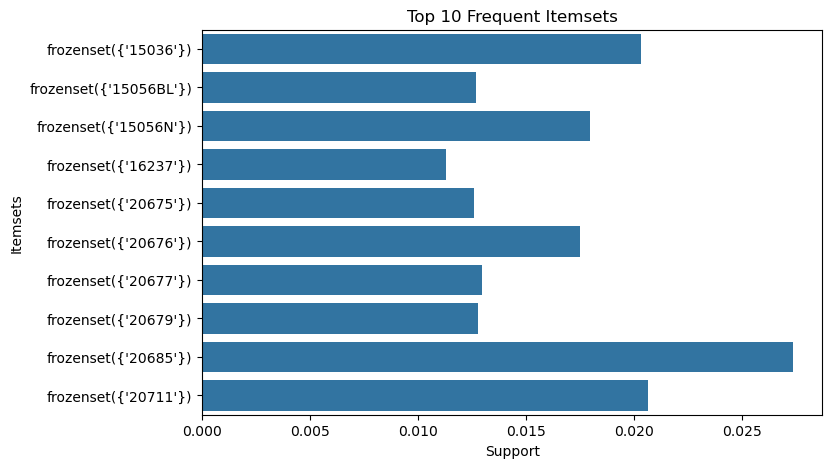

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 frequent itemsets
plt.figure(figsize=(8, 5))
sns.barplot(x=frequent_itemsets.support.head(10), y=frequent_itemsets.itemsets.head(10).astype(str))
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.show()


### INSIGHT
This chart shows the top 10 most frequent items purchased, with item '20685' being the most popular.  
The data suggests that even the most frequent items are only purchased in a small percentage of transactions.  
It's likely that these items are part of a product line or category due to the similarities in their item codes.  
Further analysis could explore bundling these items or running targeted promotions to increase sales

### Step 7: Business Application of Association Rules
Association rules, derived from techniques like Apriori, provide invaluable insights into customer behavior and product relationships, driving informed business decisions across various domains. Let's illustrate with a refined example:

Scenario: An online retailer analyzes purchase data and discovers the following rule:

antecedents: {Gaming Console} -> consequents: {Gaming Headset, Extended Warranty}
support: 0.02
confidence: 0.65
lift: 2.5

Interpretation:

* 2% of transactions include a gaming console, gaming headset, and extended warranty.
* 65% of customers who purchase a gaming console also buy a gaming headset and extended warranty.
* Customers buying a gaming console are 2.5 times more likely to purchase a headset and warranty than the average customer.

Business Decisions:

1. Bundling & Promotions:

Offer a "Gamer Bundle" with console, headset, and warranty at a discounted price, incentivizing the purchase of all three items.
Run targeted promotions for customers who purchase a console, offering discounts on headsets and warranties.

2. Product Recommendations:

* Implement a recommendation engine that suggests gaming headsets and extended warranties to customers browsing or purchasing gaming consoles.
* Personalize recommendations based on customer segments (e.g., casual vs. hardcore gamers).

3.Inventory Management:

Forecast demand for headsets and warranties based on console sales trends.
Optimize inventory levels to ensure sufficient stock of associated items.

4.Customer Segmentation & Targeting:

* Identify customer segments who frequently purchase gaming consoles and associated items.
* Tailor marketing campaigns and loyalty programs to these segments.

5.Pricing Strategies:

Analyze price sensitivity for consoles, headsets, and warranties within different customer segments.
Adjust pricing and promotions to maximize profitability.

Critical Considerations:

* Causality vs. Correlation: While the rule shows a strong association, it doesn't necessarily mean buying a console causes customers to buy a headset and warranty. Other factors, such as gaming preferences or marketing influences, could be at play.

* External Factors: Consider seasonality (e.g., holiday sales), competitor promotions, or new game releases that might influence the association.

* Data Quality: Ensure data accuracy and completeness to avoid misleading rules.

Conclusion:

By thoughtfully interpreting association rules and considering the nuances of the business context, retailers can make data-driven decisions to improve sales, customer satisfaction, and operational efficiency.